In [41]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense
from keras.callbacks import EarlyStopping


## load data and generate word cloud for visualization


In [42]:
df = pd.read_csv('processed_emails.csv')

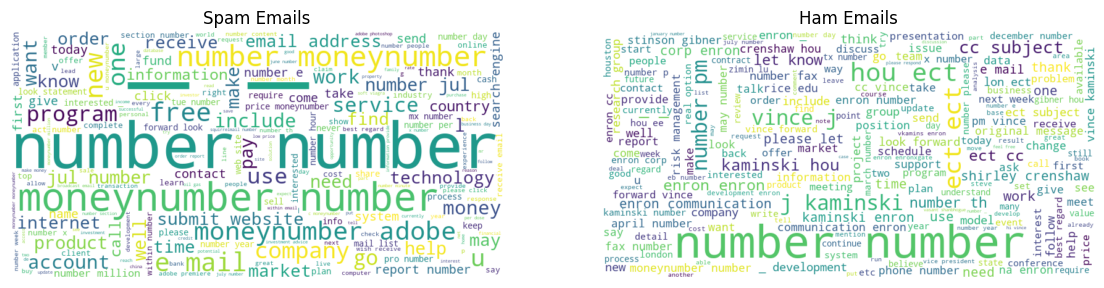

In [43]:
# Load the processed data
df = pd.read_csv('processed_emails.csv')

# Separate text for spam and ham
spam_text = ' '.join(df[df['spam'] == 1]['text'].apply(lambda x: ' '.join(eval(x))))
ham_text = ' '.join(df[df['spam'] == 0]['text'].apply(lambda x: ' '.join(eval(x))))

# Create word clouds
spam_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(spam_text)
ham_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(ham_text)

# Plot word clouds
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plt.imshow(spam_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Spam Emails')

plt.subplot(1, 2, 2)
plt.imshow(ham_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Ham Emails')

plt.show()

## check implance in data

In [44]:
class_distribution = df['spam'].value_counts()
print(class_distribution)

spam
0    4360
1    1368
Name: count, dtype: int64


## turn words into numerical values and to sequence

In [45]:
# Tokenize the text
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(df['text'].apply(lambda x: ' '.join(eval(x))))  # Join tokens for tokenizer
# Convert texts to sequences
sequences = tokenizer.texts_to_sequences(df['text'].apply(lambda x: ' '.join(eval(x))))
# Pad sequences to ensure equal length
max_sequence_length = 1000  # Get max sequence length
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length, padding='post')


## Apply SMOTE to handle data implancing 

In [46]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, df['spam'], test_size=0.2, random_state=42)

# Initialize SMOTE
smote = SMOTE(random_state=42)

# Apply SMOTE to the training data
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


In [47]:
print(X_train_resampled.shape)
print(y_train_resampled.shape)
print(X_test.shape)
print(y_test.shape)

(7008, 1000)
(7008,)
(1146, 1000)
(1146,)


## LSTM model

In [58]:
# Define LSTM model
model = Sequential()
model.add(Embedding(input_dim=10000, output_dim=50, input_length=max_sequence_length))
model.add(LSTM(units=100, return_sequences=False))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the LSTM model
history = model.fit(X_train_resampled, y_train_resampled, validation_split=0.2, epochs=20, batch_size=64)


Epoch 1/20
88/88 [==============================] - 285s 3s/step - loss: 0.6634 - accuracy: 0.6250 - val_loss: 0.9706 - val_accuracy: 7.1327e-04
Epoch 2/20
88/88 [==============================] - 433s 5s/step - loss: 0.6608 - accuracy: 0.6275 - val_loss: 0.9789 - val_accuracy: 0.0029
Epoch 3/20
88/88 [==============================] - 434s 5s/step - loss: 0.6607 - accuracy: 0.6290 - val_loss: 0.9939 - val_accuracy: 0.0071
Epoch 4/20
88/88 [==============================] - 431s 5s/step - loss: 0.6606 - accuracy: 0.6290 - val_loss: 0.9673 - val_accuracy: 0.0107
Epoch 5/20
88/88 [==============================] - 425s 5s/step - loss: 0.6677 - accuracy: 0.6252 - val_loss: 0.9559 - val_accuracy: 0.0100
Epoch 6/20
88/88 [==============================] - 392s 4s/step - loss: 0.6600 - accuracy: 0.6293 - val_loss: 0.9696 - val_accuracy: 0.0107
Epoch 7/20
88/88 [==============================] - 394s 4s/step - loss: 0.6585 - accuracy: 0.6295 - val_loss: 0.9865 - val_accuracy: 0.0136
Epoch 8/2

In [59]:
# Save the model to a file
model.save('lstm_spam_detection_model3.h5')


In [60]:
# Evaluate the model on the test data
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')


36/36 [==============================] - 9s 237ms/step - loss: 0.5972 - accuracy: 0.7478
Test Loss: 0.5971712470054626
Test Accuracy: 0.7478184700012207


36/36 [==============================] - 9s 235ms/step


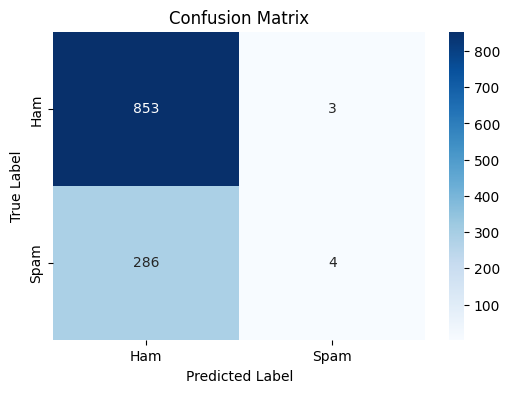

              precision    recall  f1-score   support

           0       0.75      1.00      0.86       856
           1       0.57      0.01      0.03       290

    accuracy                           0.75      1146
   macro avg       0.66      0.51      0.44      1146
weighted avg       0.70      0.75      0.65      1146



In [61]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np

# Make predictions on the test set
y_pred = (model.predict(X_test) > 0.5).astype("int32")

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print(classification_report(y_test, y_pred))


In [52]:
# Count the number of spam (1) and ham (0) in the test sample predictions
ham_count = (y_pred == 0).sum()
spam_count = (y_pred == 1).sum()

print(f"Number of ham emails predicted: {ham_count}")
print(f"Number of spam emails predicted: {spam_count}")

# Additionally, count the actual labels in the test set
actual_ham_count = (y_test == 0).sum()
actual_spam_count = (y_test == 1).sum()

print(f"Actual number of ham emails: {actual_ham_count}")
print(f"Actual number of spam emails: {actual_spam_count}")

Number of ham emails predicted: 1139
Number of spam emails predicted: 7
Actual number of ham emails: 856
Actual number of spam emails: 290


In [53]:



# Additionally, count the actual labels in the test set
ham_count = (y_train_resampled == 0).sum()
spam_count = (y_train_resampled == 1).sum()

print(f"Actual number of ham emails: {ham_count}")
print(f"Actual number of spam emails: {spam_count}")

Actual number of ham emails: 3504
Actual number of spam emails: 3504


In [54]:
len(tokenizer.word_index) + 1

29782

In [55]:
max_sequence_length

1000

In [63]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Bidirectional,SpatialDropout1D,Dropout

# Define the BiLSTM model
bilstm_model = Sequential()

# Add the embedding layer
bilstm_model.add(Embedding(input_dim=10000, output_dim=50, input_length=max_sequence_length))
bilstm_model.add(SpatialDropout1D(0.2))
# Add a bidirectional LSTM layer
bilstm_model.add(Bidirectional(LSTM(units=64, return_sequences=True)))
# Add a bidirectional LSTM layer
bilstm_model.add(Bidirectional(LSTM(units=64)))
bilstm_model.add(Dropout(0.2))
# Add a Dense layer for binary classification (spam or ham)
bilstm_model.add(Dense(1, activation='sigmoid'))

# Compile the model
bilstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display the model architecture
bilstm_model.summary()

# Train the BiLSTM model
bilstm_model.fit(X_train_resampled, y_train_resampled, validation_split=0.2, epochs=10, batch_size=64)

# Save the BiLSTM model
bilstm_model.save('bilstm_spam_detection_model.h5')


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 1000, 50)          500000    
                                                                 
 spatial_dropout1d (SpatialD  (None, 1000, 50)         0         
 ropout1D)                                                       
                                                                 
 bidirectional_1 (Bidirectio  (None, 1000, 128)        58880     
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                      

In [64]:
# Evaluate the model on the test data
bi_loss, bi_accuracy = bilstm_model.evaluate(X_test, y_test)
print(f'Test Loss: {bi_loss}')
print(f'Test Accuracy: {bi_accuracy}')


36/36 [==============================] - 19s 538ms/step - loss: 0.2308 - accuracy: 0.9511
Test Loss: 0.23084156215190887
Test Accuracy: 0.9511343836784363


36/36 [==============================] - 22s 563ms/step


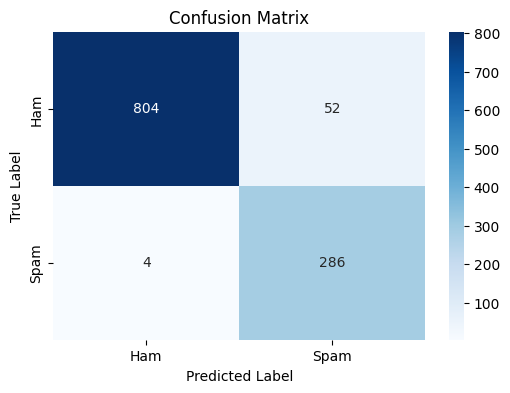

              precision    recall  f1-score   support

           0       1.00      0.94      0.97       856
           1       0.85      0.99      0.91       290

    accuracy                           0.95      1146
   macro avg       0.92      0.96      0.94      1146
weighted avg       0.96      0.95      0.95      1146



In [65]:
# Make predictions on the test set
y_pred_bi = (bilstm_model.predict(X_test) > 0.5).astype("int32")

# Confusion matrix
conf_matrix_bi = confusion_matrix(y_test, y_pred_bi)

# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_bi, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print(classification_report(y_test, y_pred_bi))